In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import random

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt             
import matplotlib as mpl                    
mpl.rc('font', family='Malgun Gothic')      
plt.rcParams['axes.unicode_minus'] = False  

import tensorflow as tf
from tensorflow import keras  
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import glob
from matplotlib.image import imread
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [42]:
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# CelebA 
## 데이터 로드 및 저장
- DataSet: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset

In [45]:
# 필요시 >> 이미지가 너무 많아서 랜덤하게 100개 추출
# train_dir='./Data/img_align_celeba/original/'
# images=random.sample(os.listdir(train_dir), 100)
# len(images)

In [38]:
# save_dir='./Data/img_align_celeba/gan_img/real/'

# for i, img_name in enumerate(images):
#     img_path=os.path.join(train_dir, img_name)
#     img=imread(img_path)
#     img_pil=Image.fromarray(img)           # PIL 이미지로 변환

#     # 이미지 저장
#     save_path=os.path.join(save_dir, img_name)
#     img_pil.save(save_path)
# print(f"저장 완료: {save_path}")

['000426.jpg', '001640.jpg', '001740.jpg', '001953.jpg', '002083.jpg', '002848.jpg', '003004.jpg', '004559.jpg', '004680.jpg', '005165.jpg']


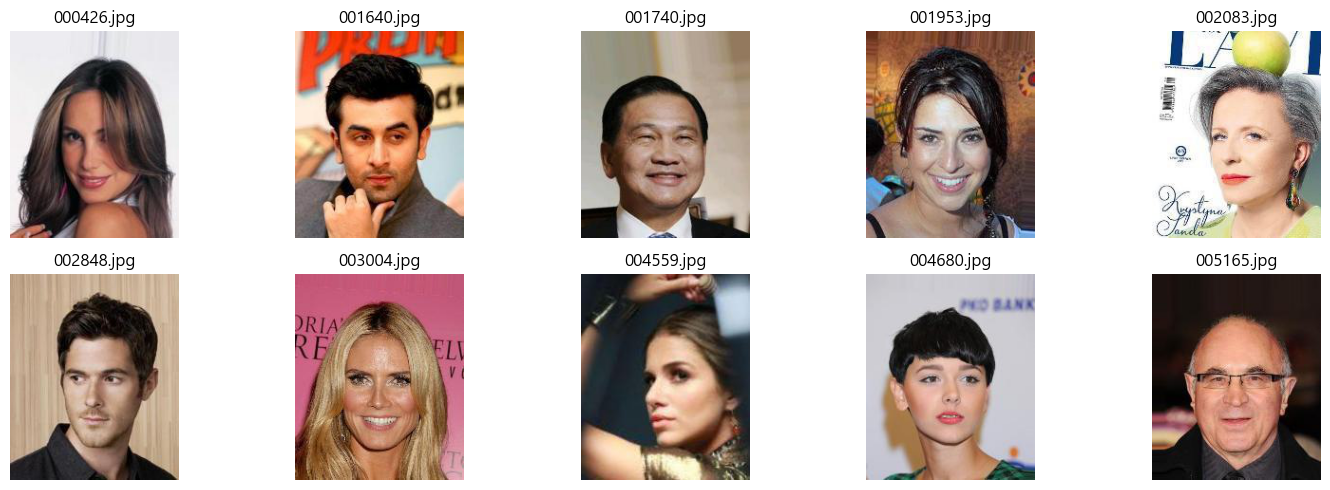

In [51]:
train_dir='./Data/img_align_celeba/gan_img/real'
images=os.listdir(train_dir)
print(images[:10])

plt.figure(figsize=(15, 5))
for i, img_name in enumerate(images[:10]):
    img_path=os.path.join(train_dir, img_name)
    img=imread(img_path)

    # 이미지 출력
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(img_name)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [82]:
def load_celeba_images(path, img_shape=(64, 64)):
    images=[]
    img_paths=glob.glob(os.path.join(path, '*.jpg'))
    # print(img_paths)
    
    for img_path in img_paths:
        img=load_img(img_path, target_size=img_shape)
        img=img_to_array(img)
        img=(img / 255.0) * 2 - 1  #  img=(img - 127.5) / 127.5 
        images.append(img)
    return np.array(images)

In [87]:
X_train=load_celeba_images(train_dir)  
X_train.shape

(10, 64, 64, 3)

## 생성자 모델 (Generator Model)

In [17]:
g_model=Sequential()
g_model.add(keras.layers.Input(shape=(100, )))     
g_model.add(keras.layers.Dense(256 * 8 * 8))
g_model.add(keras.layers.LeakyReLU(0.2))
g_model.add(keras.layers.BatchNormalization())
g_model.add(keras.layers.Reshape((8, 8, 256)))

g_model.add(keras.layers.UpSampling2D())
g_model.add(keras.layers.Conv2D(128, kernel_size=5, padding='same'))
g_model.add(keras.layers.LeakyReLU(0.2))
g_model.add(keras.layers.BatchNormalization())

g_model.add(keras.layers.UpSampling2D())
g_model.add(keras.layers.Conv2D(64, kernel_size=5, padding='same'))
g_model.add(keras.layers.LeakyReLU(0.2))
g_model.add(keras.layers.BatchNormalization())

g_model.add(keras.layers.UpSampling2D())
g_model.add(keras.layers.Conv2D(3, kernel_size=5, padding='same', activation='tanh'))
# g_model.summary()

## 판별자 모델 (Discriminator Model)

In [20]:
d_model=Sequential()
d_model.add(keras.layers.Input(shape=(64, 64, 3)))

d_model.add(keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same"))
d_model.add(keras.layers.LeakyReLU(0.2))
d_model.add(keras.layers.Dropout(0.3))

d_model.add(keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same"))
d_model.add(keras.layers.LeakyReLU(0.2))
d_model.add(keras.layers.Dropout(0.3))

d_model.add(keras.layers.Flatten())
d_model.add(keras.layers.Dense(1, activation='sigmoid'))
# d_model.summary()

d_model.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])
d_model.trainable=False

## GAN 모델 생성 - 판별자 + 생성자 연결 모델 구성

In [23]:
g_input=keras.Input(shape=(100,))     # 랜덤한 100개의 벡터
d_ouput=d_model(g_model(g_input))     # 노이즈 입력 >> 28*28 결과 >> 참, 거짓

gan=Model(g_input, d_ouput)
gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])    # 참과 거짓 구분
gan.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 64, 64, 3)           │       2,750,083 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 1)                   │         242,561 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,992,644 (11.42 MB)

 Trainable params: 2,716,931 (10.36 MB)

 Non-trainable params: 275,713 (1.05 MB)

## 학습 함수 정의

In [30]:
def gan_train(epoch, batch_size, saving_interval):
    true=np.ones((batch_size, 1))
    fake=np.zeros((batch_size, 1))

    for i in range(epoch):
         # 실제 데이터를 판별자에 입력
        d_model.trainable=True
        idx=np.random.randint(0, X_train.shape[0], batch_size)
        imgs=X_train[idx]
        d_loss_real=d_model.train_on_batch(imgs, true)

        # 가상 이미지를 판별자에 입력
        noise=np.random.normal(0, 1, (batch_size, 100))
        g_imgs=g_model.predict(noise, verbose=0)
        d_loss_fake=d_model.train_on_batch(g_imgs, fake)

        # 오차계산 
        d_loss=0.5 * np.add(d_loss_real, d_loss_fake)
        d_model.trainable=False
        gan_loss=gan.train_on_batch(noise, true)

        if i % saving_interval == 0:
                print('epoch:%d' % i, ' d_loss:%.4f' % d_loss[0], 'd_accuracy:%.4f' % d_loss[1], 
                      ' gan_loss:%.4f' % gan_loss[0], 'gen_accuracy:%.4f' % gan_loss[1])
                
                noise=np.random.normal(0, 1, (10, 100))
                g_imgs=g_model.predict(noise, verbose=0)
                g_imgs=0.5 * g_imgs + 0.5   # tanh >> 0 ~ 255
    
                fig, axs=plt.subplots(2, 5)
                count=0
                for j in range(2):
                    for k in range(5):
                        axs[j, k].imshow(g_imgs[count])
                        axs[j, k].axis('off')
                        count +=1
                fig.savefig("./Deep_result/gen_celeba/celeba_gan_%d.png" % i)
                plt.close(fig)

In [32]:
gan_train(100, 25, 200)

epoch:0  d_loss:0.2308 d_accuracy:0.7726  gan_loss:0.0508 gen_accuracy:1.0000
epoch:200  d_loss:0.0376 d_accuracy:0.9631  gan_loss:0.0083 gen_accuracy:1.0000
